In [1]:
import matplotlib.pyplot as plt

from src.utils import *
import os
import IPython.display as ipd
import logging
from src.resnet_model import SpectrogramModel
from src.SENet.SENet_model import se_resnet34_custom
import torch.nn as nn
import librosa


logging.getLogger('numba').setLevel(logging.WARNING)
logging.getLogger('matplotlib.font_manager').disabled = True
logging.getLogger('matplotlib.colorbar').disabled = True
logging.getLogger('matplotlib.pyplot').disabled = True

In [2]:
config_path = '../config/residualnet_train_config.yaml'
config_res = read_yaml(config_path)


In [3]:
seed_everything(1234)
set_gpu(-1)
plt.style.use('dark_background')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

GPU selected: 0 - Quadro P6000


***
## Parameters

In [4]:
win_length = 2048
n_fft = 2048
hop_length = 512
window = 'hann'

***
## Load the audio file

In [5]:
# load one file
file_number = 8110643
label = np.array([1])
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_eval/flac/LA_E_{file_number}.flac'
clean_audio, _ = librosa.load(path_to_original, sr=16000)

In [6]:
print('Original Audio Length: ', len(clean_audio))

Original Audio Length:  57721


In [7]:
clean_audio = clean_audio[:47104]   #so that we get the exact length to be fed the model with
print('New Audio Length: ', len(clean_audio))

New Audio Length:  47104


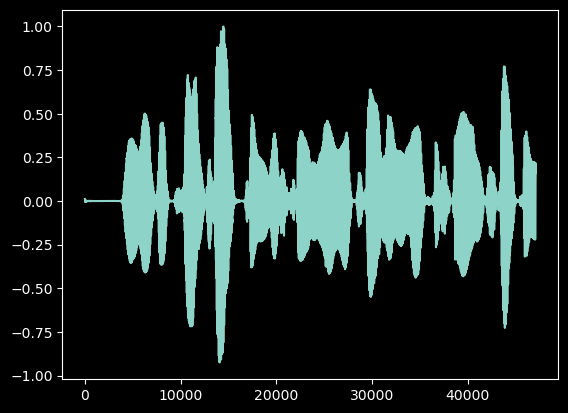

In [8]:
plt.figure()
plt.plot(clean_audio)
plt.show()

In [9]:
ipd.Audio(clean_audio, rate=16000)

***
## Store the original phase

In [10]:
s = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
# s = s[:, :84]  # net input shape for the model

phase = np.angle(s)
phase.shape

(1025, 93)

***
## Compute the power spectrogram

In [11]:
a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)
pow_spec.shape

(1025, 93)

***
## Recover the audio

In [13]:
# recover magnitude spectrogram spec
lin_a = librosa.db_to_power(pow_spec)
mag_a = np.sqrt(lin_a)
print(f'Shape of magnitude spectrogram: {mag_a.shape} \nShape of the phase: {phase.shape}')


Shape of magnitude spectrogram: (1025, 93) 
Shape of the phase: (1025, 93)


In [14]:
recon_a = librosa.istft(mag_a * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)  #length=3*16000

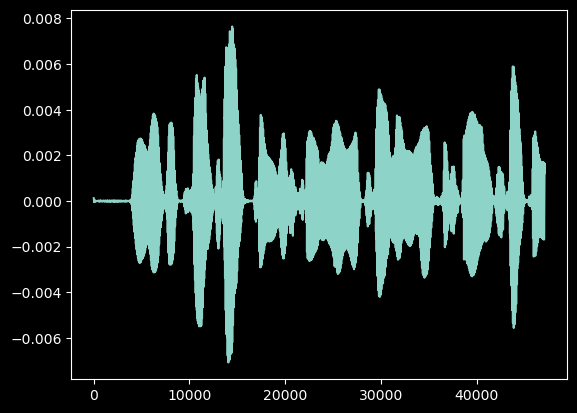

In [15]:
plt.figure()
plt.plot(recon_a)
plt.show()

In [16]:
ipd.Audio(recon_a, rate=16000)

In [17]:
print(clean_audio.shape)
print(recon_a.shape)

(47104,)
(47104,)


In [18]:
print(f'Length of the reconverted audio is {len(recon_a)}')

Length of the reconverted audio is 47104


***
## Re-evaluation

In [19]:
# compute power spectrogram
p_mag_spec = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
b = np.abs(p_mag_spec) ** 2
pow_spec = librosa.power_to_db(b, ref=np.max)

p_mag_spec2 = librosa.stft(recon_a, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
b2 = np.abs(p_mag_spec2) ** 2
pow_spec2 = librosa.power_to_db(b2, ref=np.max)

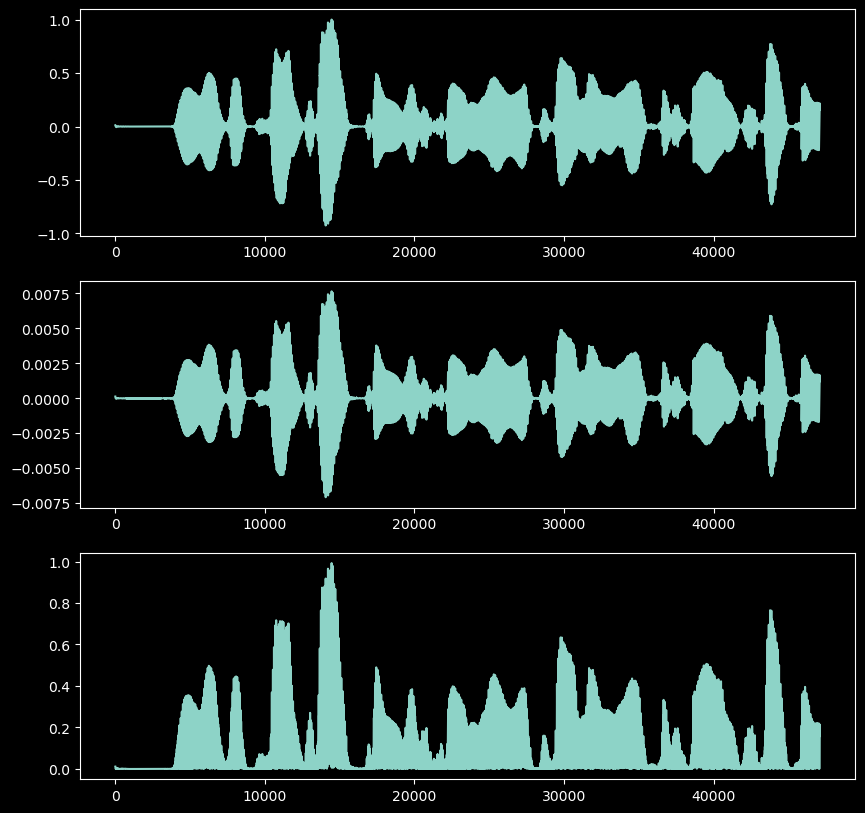

In [20]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
plt.plot(clean_audio, label='clean')
plt.subplot(3,1,2)
plt.plot(recon_a)
plt.subplot(3,1,3)
plt.plot(np.abs(clean_audio)-np.abs(recon_a))
plt.show()

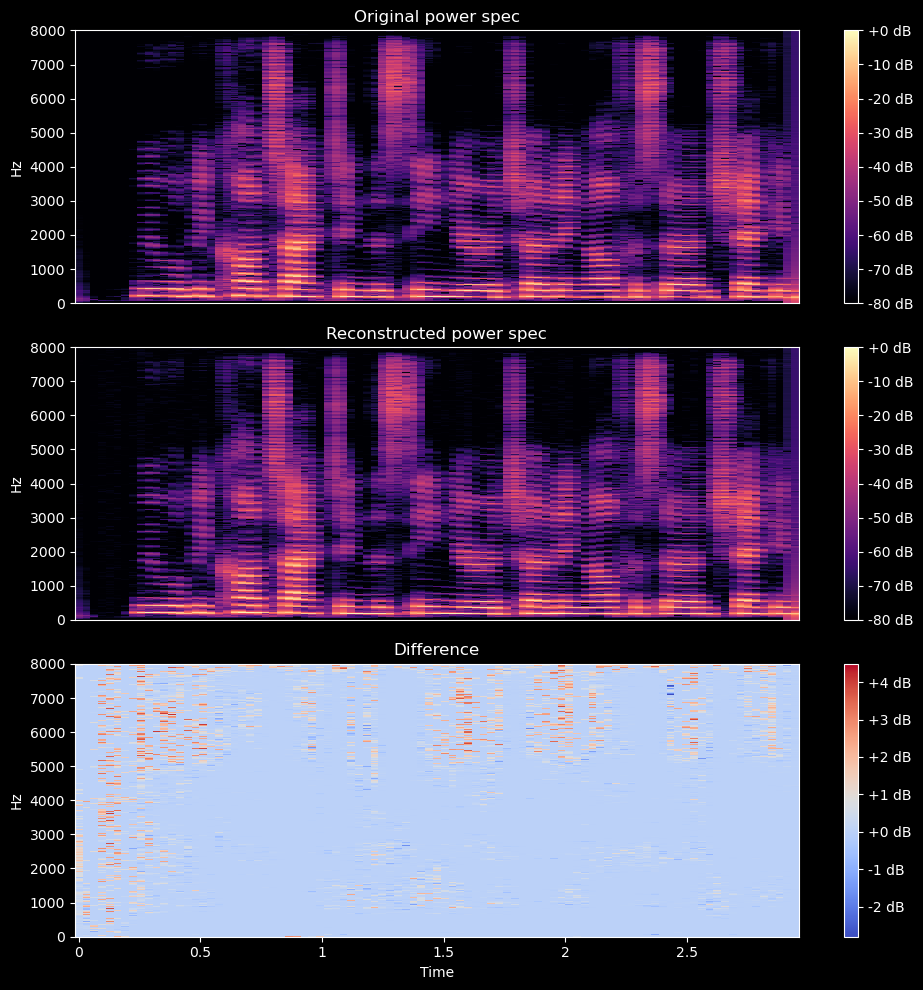

In [21]:
plt.figure(figsize=(10,10))
plt.subplot(3,1,1)
librosa.display.specshow(pow_spec, sr=16000,  y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title(f'Original power spec')
plt.subplot(3,1,2)
librosa.display.specshow(pow_spec2, sr=16000,  y_axis='hz')
plt.colorbar(format='%+2.0f dB')
plt.title('Reconstructed power spec')
plt.subplot(3,1,3)
librosa.display.specshow(pow_spec2-pow_spec, sr=16000, x_axis='time', y_axis='hz')
plt.colorbar(format='%+2.0f dB')    
plt.title(f'Difference')
plt.tight_layout()
plt.show()

In [22]:
np.sum(pow_spec - pow_spec2)


-10638.771

***
## Models

In [23]:
model_name = 'ResNet' #'SENet'
epsilon = 3.0

if model_name == 'ResNet':
    config_path = '../config/residualnet_train_config.yaml'
    config = read_yaml(config_path) 
    df_eval = pd.read_csv(os.path.join('..', config['df_eval_path_3s']))
    model = SpectrogramModel().to(device)
    model.load_state_dict(torch.load(os.path.join('..', config['model_path_spec_pow']), map_location=device), strict=False)
    model.eval()
elif model_name == 'SENet':
    config_SENet_path = '../config/SENet.yaml'
    config_SENet = read_yaml(config_SENet_path)
    df_eval = pd.read_csv(os.path.join('..', config_SENet['df_eval_path_3s']))
    model = se_resnet34_custom(num_classes=2).to(device)
    model.load_state_dict(torch.load(os.path.join('..', config_SENet['model_path_spec_pow']), map_location=device), strict=False)
    model.eval()
else:
    print('Wrong model')

***
## ATTACK!!!

In [31]:
#batch_x = torch.from_numpy(clean_audio).to(device)
s = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
#phase = np.angle(s)
a = np.abs(s) ** 2
batch = librosa.power_to_db(a, ref=np.max)
batch_x = torch.from_numpy(batch).unsqueeze(dim=0).to(device)
batch_x.requires_grad = True

print(f'Batch shape: {batch_x.shape}')

Batch shape: torch.Size([1, 1025, 93])


In [30]:
if model_name == 'ResNet':
    out = model(batch_x)
elif model_name == 'SENet':
    out = model(batch_x.unsqueeze(dim=1))

#print(f'{model_name} model prediction is {torch.argmax(out)} with {out}')

RuntimeError: Input type (c10::complex<float>) and bias type (float) should be the same

In [ ]:
batch_y = torch.from_numpy(label).to(device)
L = nn.NLLLoss()
loss = L(out, batch_y)
model.zero_grad()
loss.backward()
grad = batch_x.grad.data
print(f'Grad shape is {grad.shape}')

In [ ]:
p_batch = batch_x + epsilon * grad.sign()

In [ ]:
# temp = grad.clone().squeeze().detach().cpu().numpy()
# plt.figure(figsize=(10,5))
# librosa.display.specshow(temp, sr=16000)
# plt.colorbar()
# plt.title('SENet gradient')
# plt.show()

In [ ]:
# eps_low = 4.0
# eps_high = 2.0
# batch_low = batch_x[:1025//2,:]
# batch_high = batch_x[1025//2:,:]
# grad_low = grad[:1025//2,:]
# grad_high = grad[1025//2:,:]
# p_batch_low = batch_low + eps_low*grad_low.sign()
# p_batch_high = batch_high + eps_high*grad_high.sign()
# p_batch = torch.cat((p_batch_low, p_batch_high), dim=0)

In [ ]:
if model_name == 'ResNet':
    out_ = model(p_batch)
else:
    out_ = model(p_batch.unsqueeze(dim=1))

In [ ]:
print(f'{model_name} model prediction is {torch.argmax(out_)} with {out_}')

In [ ]:
# recover magnitude spectrogram spec
p_batch = p_batch.clone().squeeze().detach().cpu().numpy()
pert_spec = p_batch
lin_pert_spec = librosa.db_to_power(pert_spec)
mag_pert_spec = np.sqrt(lin_pert_spec)

In [ ]:
recon_pert_audio = librosa.istft(mag_pert_spec * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, center=True)  #length=3*16000

In [ ]:
ipd.Audio(recon_pert_audio, rate=16000)

***
## Get the perturbed audio and re-evaluate it

In [ ]:
p_mag_spec = librosa.stft(recon_pert_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
#p_mag_spec = p_mag_spec[:, :84]  # net input shape
b = np.abs(p_mag_spec) ** 2
p_pow_spec = librosa.power_to_db(b)

In [ ]:
batch_x = torch.from_numpy(p_pow_spec).unsqueeze(dim=0).to(device)
batch_x.requires_grad = True
batch_x.shape

In [ ]:
if model_name == 'ResNet':
    out = model(batch_x)
elif model_name == 'SENet':
    out = model(batch_x.unsqueeze(dim=1))

print(f'{model_name} model prediction is {torch.argmax(out)} with {out}')

In [67]:
# if p_pow_spec.shape[1] < 84:
#     num_repeats = int(84 / p_pow_spec.shape[1]) + 1
#     X = np.tile(b, (1, num_repeats))
#     # feature_len = X.shape[1]
# 
#     X_win = X[:, : 84]
#     X_win = torch.tensor(X_win)

***
## Tests on audio length

In [68]:
file_number = 1608170
label = np.array([1])
path_to_original = f'/nas/public/dataset/asvspoof2019/LA/ASVspoof2019_LA_train/flac/LA_T_{file_number}.flac'
clean_audio, _ = librosa.load(path_to_original, sr=16000)
print(f'Original file length is {len(clean_audio)}')

Original file length is 32055


In [69]:
ipd.Audio(clean_audio, rate=16000)

In [70]:
s = librosa.stft(clean_audio, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)
feature_len = pow_spec.shape[1]
feature_len

63

In [71]:
if feature_len < 93:
    num_repeats = int(93/feature_len)+1
    X = np.tile(pow_spec, (1, num_repeats))
    X = X[:, :93]
else:
    X = pow_spec[:, :93]

In [72]:
X.shape

(1025, 93)

In [73]:
X = X[:, :feature_len]
lin_a = librosa.db_to_power(S_db=X)
mag_a = np.sqrt(lin_a)

In [74]:
recon_a = librosa.istft(mag_a * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)  

In [75]:
len(recon_a)

31744

In [76]:
audio_len = len(clean_audio)
if audio_len < 47104:
    num_repeats = int(47104/feature_len)+1
    X = np.tile(clean_audio, num_repeats)
    X = X[:47104]
else:
    X = clean_audio[:47104]
X.shape

(47104,)

In [77]:
s = librosa.stft(X, n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)
phase = np.angle(s)
a = np.abs(s) ** 2
pow_spec = librosa.power_to_db(a, ref=np.max)
X = pow_spec
lin_a = librosa.db_to_power(S_db=X)
mag_a = np.sqrt(lin_a)
recon_a = librosa.istft(mag_a * np.exp(1j * phase), n_fft=n_fft, win_length=win_length, hop_length=hop_length, window=window, center=True)  
len(recon_a)

47104

In [78]:
ipd.Audio(recon_a, rate=16000)

In [79]:
recon_a = recon_a[:len(clean_audio)]

In [80]:
ipd.Audio(recon_a, rate=16000)